<a href="https://colab.research.google.com/github/ani98622/CNN-Traffic-Signal-Classification/blob/main/traffic_signals_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Downloading the data directly from Kaggle

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'gtsrb-german-traffic-sign:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F82373%2F191501%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240828%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240828T122236Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D563cc6a3e6c2f0889b980f65ad830612e76512561703d00400e4f78ddad3e3b0a9f5c9049ba3dcb628ef62d812ab925b36682a5c82bf5b9e7860c1b6c766ca44504b63384fe87f0efa6764c49fa309655c0b0b77984a9c0dff5249c01a3dfa15ec88686b10601fb00ac7abaa45a2ea8ecd374f55a5a0669704376bdbd911a7c15eb8cc9f79f6c661e88d16c57ee5b93699128951e8cc540ac3be72008d4cec9312da57325cd7bbaa6949a280b2b8da74cbf6512d14181fab5e0a4a261bf932e23cb24ee14fd2ba986c0bd6e618c8a0f68bc0581160198ff6df153910061ce09ae2c12bce26d28ce686533238323c4192e1c45a98675d153c22fa5694b5ec3d2f'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 641568792 bytes downloaded
Downloaded and uncompressed: gtsrb-german-traffic-sign
Data source import complete.


## Traffic Sign Recognizer

- Mount drive

In [70]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Importing Required Libraries

In [2]:
import numpy as np, pandas as pd, os, cv2, matplotlib.pyplot as plt, tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import accuracy_score
np.random.seed(42)

from matplotlib import style
style.use('fivethirtyeight')

## Assigning Path for Dataset

In [3]:
data_dir = '../input/gtsrb-german-traffic-sign'
train_path = '../input/gtsrb-german-traffic-sign/Train'
test_path = '../input/gtsrb-german-traffic-sign/'

# Resizing the images to 30x30x3
IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3

## Finding Total Classes

In [4]:
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

43

In [5]:
# Label Overview
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)',
            2:'Speed limit (50km/h)',
            3:'Speed limit (60km/h)',
            4:'Speed limit (70km/h)',
            5:'Speed limit (80km/h)',
            6:'End of speed limit (80km/h)',
            7:'Speed limit (100km/h)',
            8:'Speed limit (120km/h)',
            9:'No passing',
            10:'No passing veh over 3.5 tons',
            11:'Right-of-way at intersection',
            12:'Priority road',
            13:'Yield',
            14:'Stop',
            15:'No vehicles',
            16:'Veh > 3.5 tons prohibited',
            17:'No entry',
            18:'General caution',
            19:'Dangerous curve left',
            20:'Dangerous curve right',
            21:'Double curve',
            22:'Bumpy road',
            23:'Slippery road',
            24:'Road narrows on the right',
            25:'Road work',
            26:'Traffic signals',
            27:'Pedestrians',
            28:'Children crossing',
            29:'Bicycles crossing',
            30:'Beware of ice/snow',
            31:'Wild animals crossing',
            32:'End speed + passing limits',
            33:'Turn right ahead',
            34:'Turn left ahead',
            35:'Ahead only',
            36:'Go straight or right',
            37:'Go straight or left',
            38:'Keep right',
            39:'Keep left',
            40:'Roundabout mandatory',
            41:'End of no passing',
            42:'End no passing veh > 3.5 tons' }

## Visualizing The Dataset

In [6]:
folders = os.listdir(train_path)

train_number = []
class_num = []

In [7]:
folders

['23',
 '22',
 '24',
 '3',
 '29',
 '20',
 '17',
 '25',
 '19',
 '11',
 '10',
 '41',
 '28',
 '37',
 '12',
 '18',
 '33',
 '26',
 '2',
 '39',
 '0',
 '31',
 '42',
 '8',
 '13',
 '30',
 '38',
 '16',
 '34',
 '4',
 '40',
 '35',
 '32',
 '14',
 '15',
 '36',
 '21',
 '9',
 '7',
 '27',
 '5',
 '6',
 '1']

In [72]:
for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])

# Sorting the dataset on the basis of number of images in each class
zipped_lists = list(zip(train_number, class_num))
sorted_pairs = sorted(zipped_lists)

# Unzipping the sorted pairs
train_number, class_num = zip(*sorted_pairs)

# Converting the tuples back to lists
train_number = list(train_number)
class_num = list(class_num)

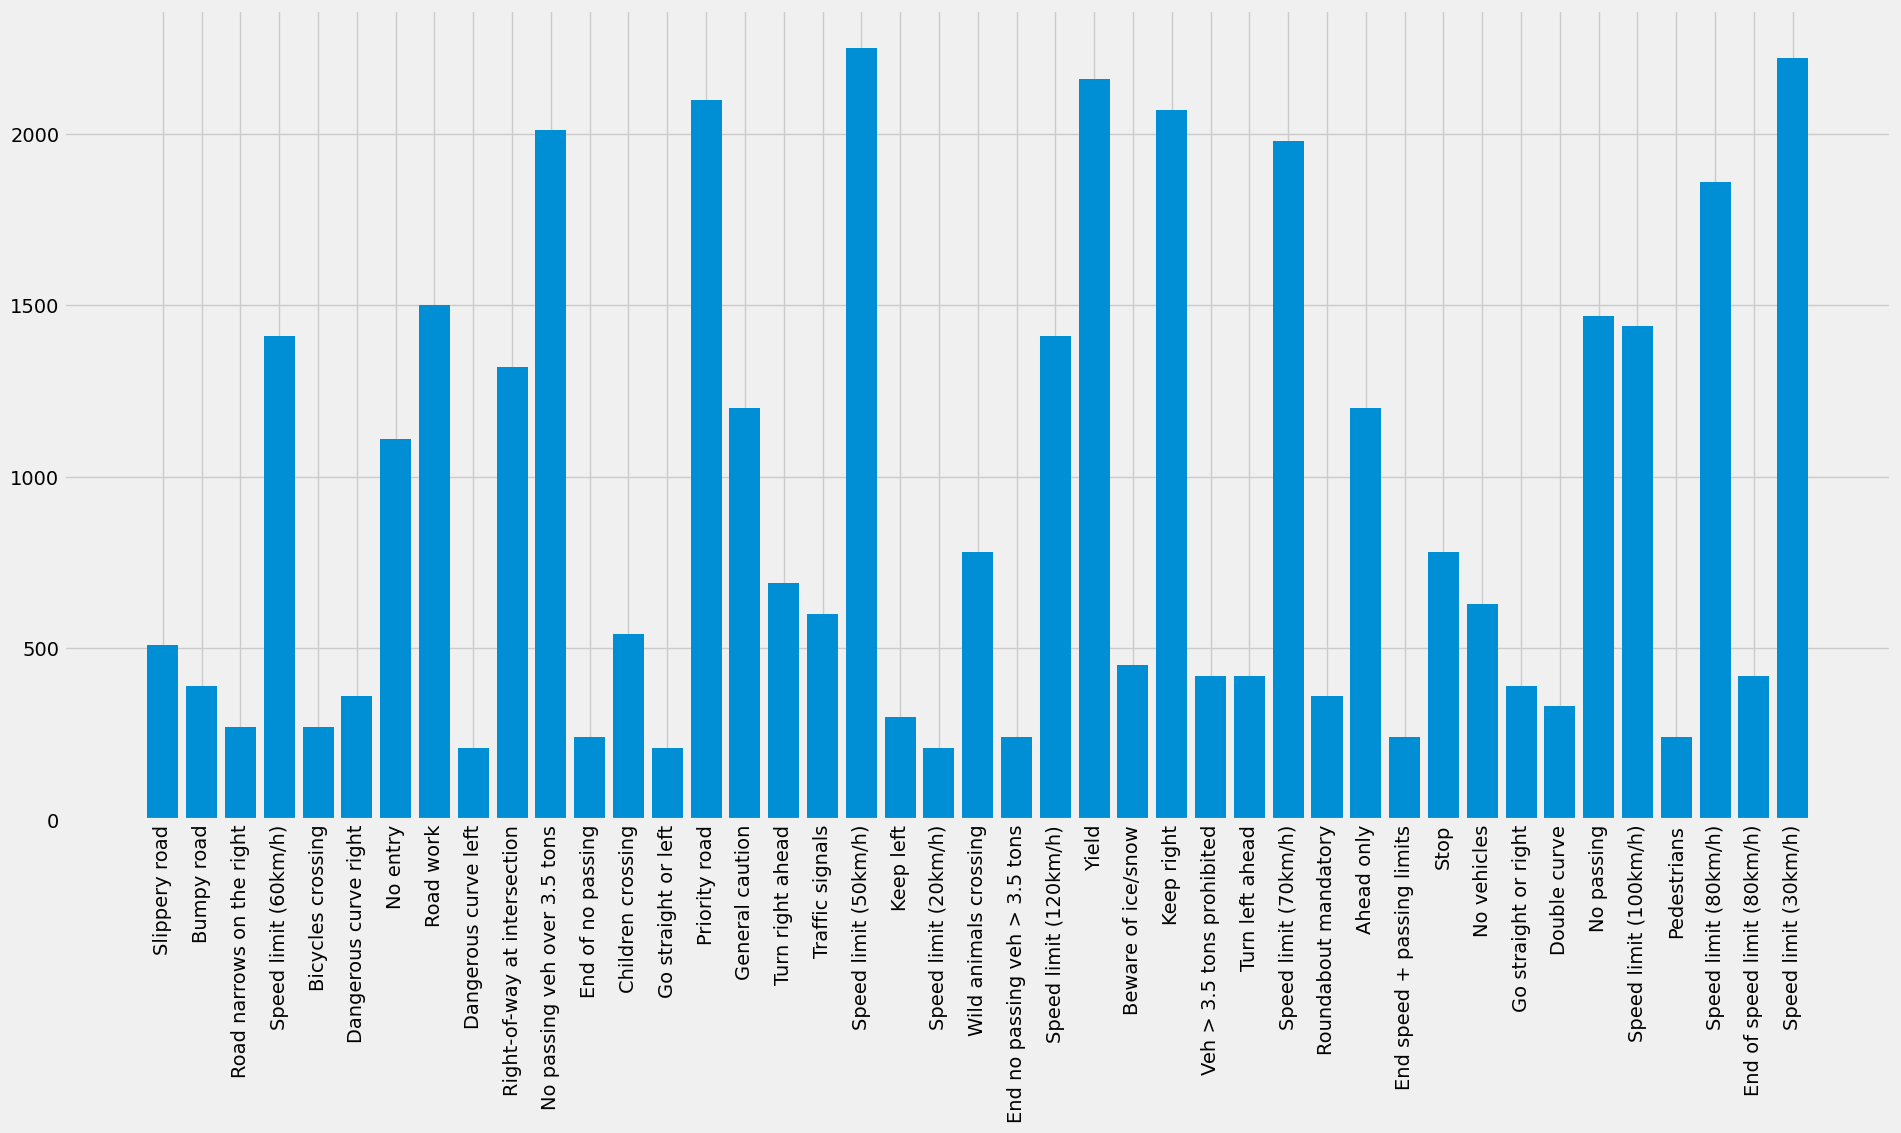

In [37]:
# Plotting the number of images in each class
plt.figure(figsize=(21,10))
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

- Visualizing 25 random images from test data

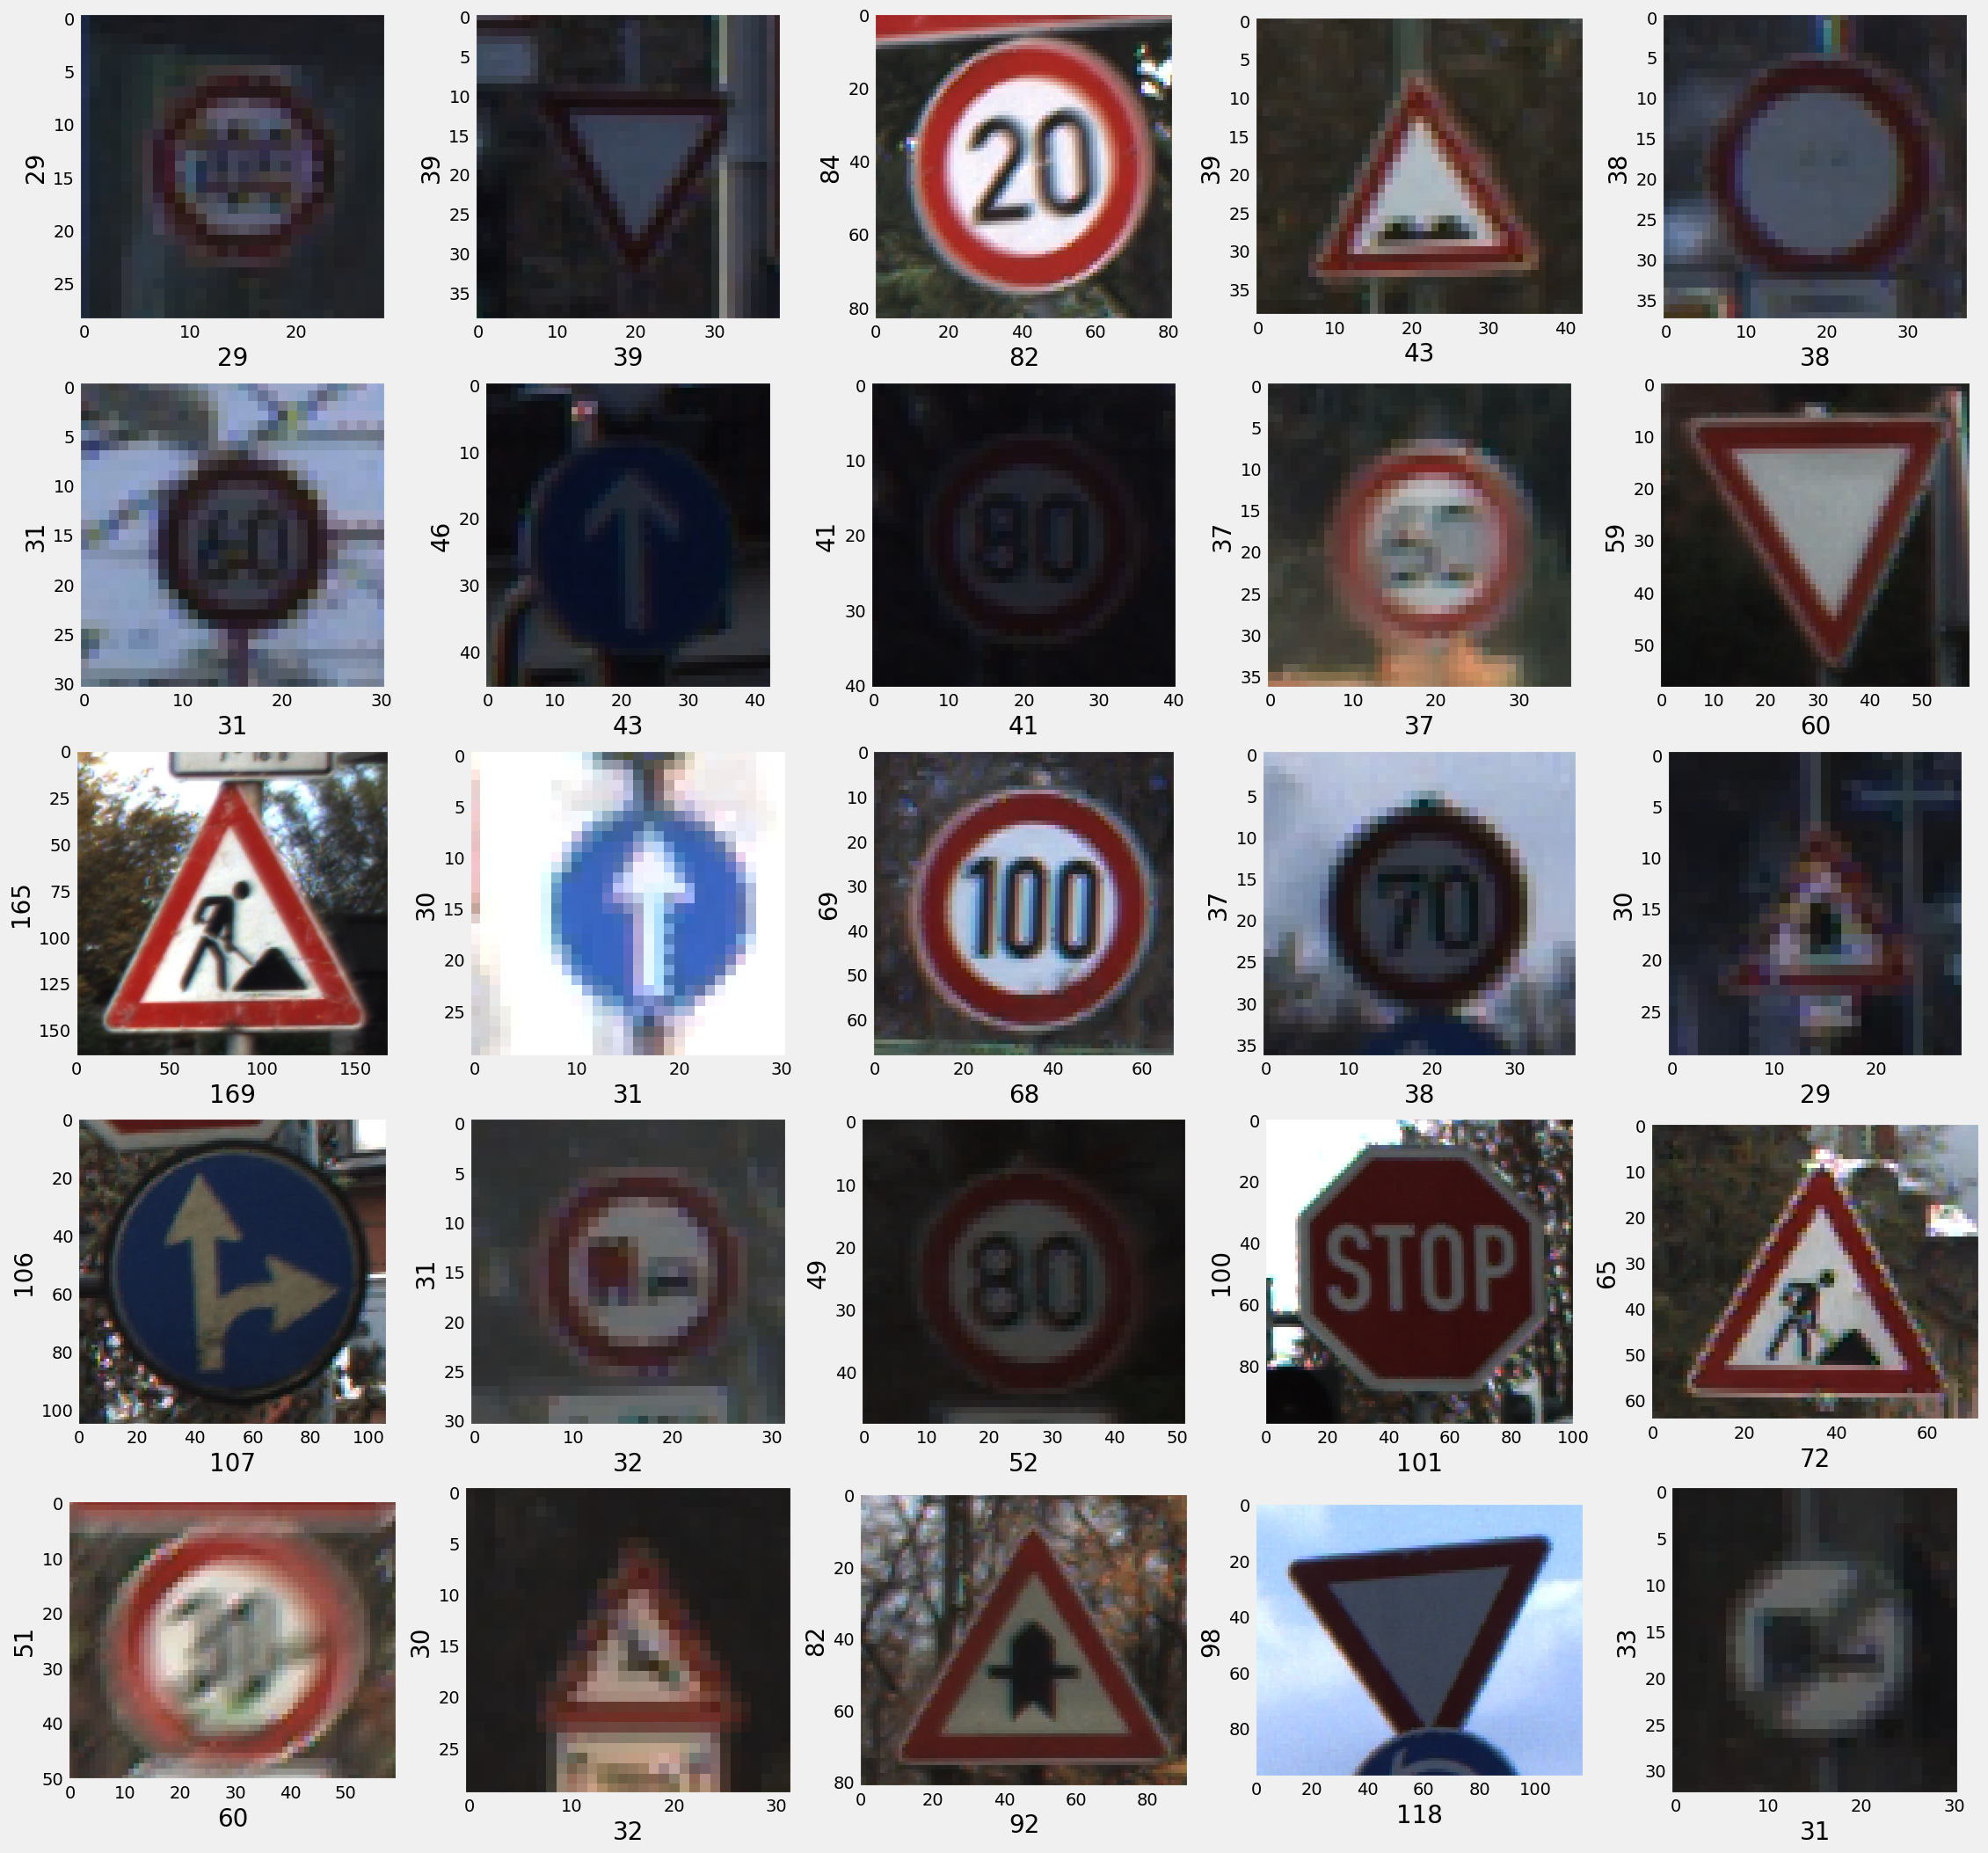

In [41]:
import random
from matplotlib.image import imread

test = pd.read_csv(data_dir + '/Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(25,25))

for i in range(1,26):
    plt.subplot(5,5,i)
    random_img_path = data_dir + '/' + random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.grid()
    plt.xlabel(rand_img.shape[1], fontsize = 20)  #width of image
    plt.ylabel(rand_img.shape[0], fontsize = 20)  #height of image

## Collecting the Training Data

In [42]:
image_data = []
image_labels = []

for i in range(NUM_CATEGORIES):
    path = data_dir + '/Train/' + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in " + img)

# Changing the list to numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

(39209, 30, 30, 3) (39209,)


## Shuffling the training data

In [43]:
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

## Splitting the data into train and validation set

In [44]:
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train/255
X_val = X_val/255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (27446, 30, 30, 3)
X_valid.shape (11763, 30, 30, 3)
y_train.shape (27446,)
y_valid.shape (11763,)


## One hot encoding the labels

In [45]:
y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)
y_val = keras.utils.to_categorical(y_val, NUM_CATEGORIES)

print(y_train.shape)
print(y_val.shape)

(27446, 43)
(11763, 43)


## Making the model

In [46]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,channels)),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),

    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),

    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),

    keras.layers.Dense(43, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [50]:
from tensorflow.keras.optimizers import Adam

lr = 0.001
epochs = 30

opt = Adam(learning_rate = lr,weight_decay = lr / (epochs * 0.5))
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

## Augmenting the data and training the model

In [51]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

history = model.fit(aug.flow(X_train, y_train, batch_size=32), epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


858/858 ━━━━━━━━━━━━━━━━━━━━ 35s 31ms/step - accuracy: 0.4886 - loss: 2.0929 - val_accuracy: 0.9422 - val_loss: 0.1818
Epoch 2/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - accuracy: 0.9304 - loss: 0.2249 - val_accuracy: 0.9792 - val_loss: 0.0671
Epoch 3/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.9628 - loss: 0.1209 - val_accuracy: 0.9844 - val_loss: 0.0493
Epoch 4/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.9660 - loss: 0.1104 - val_accuracy: 0.9936 - val_loss: 0.0245
Epoch 5/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 39s 24ms/step - accuracy: 0.9775 - loss: 0.0762 - val_accuracy: 0.9959 - val_loss: 0.0133
Epoch 6/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 26s 31ms/step - accuracy: 0.9813 - loss: 0.0650 - val_accuracy: 0.9695 - val_loss: 0.0962
Epoch 7/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 30s 35ms/step - accuracy: 0.9800 - loss: 0.0593 - val_accuracy: 0.9966 - val_loss: 0.0136
Epoch 8/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.9820 - loss: 0.0570 - val_accurac

- Loss plot

In [53]:
import matplotlib.pyplot as plt

def plot_loss(history):
    """
    Plots the training and validation loss from the model's training history.

    Parameters:
    history (keras.callbacks.History): The history object returned from model.fit().
    """
    # Extract loss values from the history object
    train_loss = history.history.get('loss')
    val_loss = history.history.get('val_loss')

    # Check if the loss values are available
    if train_loss is None or val_loss is None:
        raise ValueError("Loss data is not available in the history object.")

    epochs = range(1, len(train_loss) + 1)

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

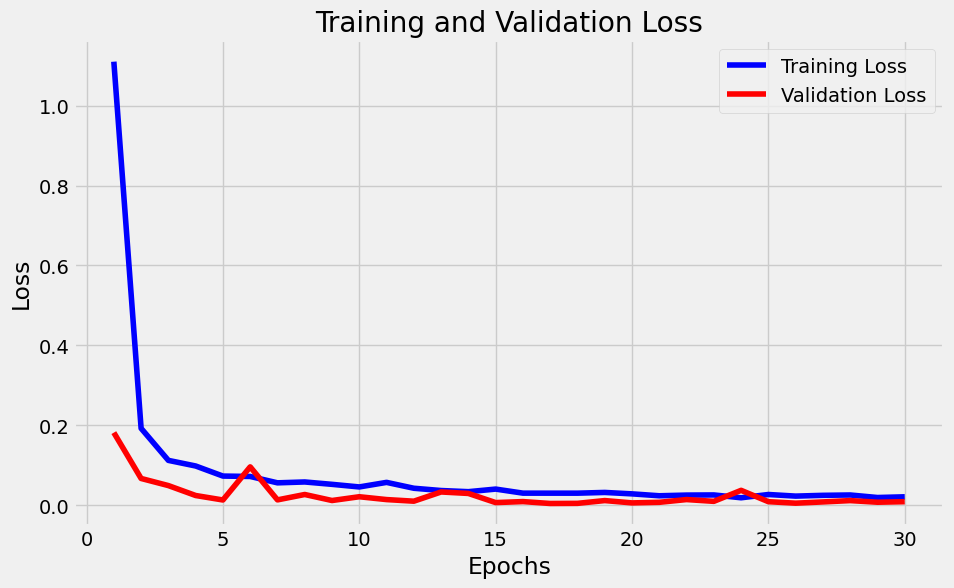

In [54]:
plot_loss(history)

## Evaluating the model

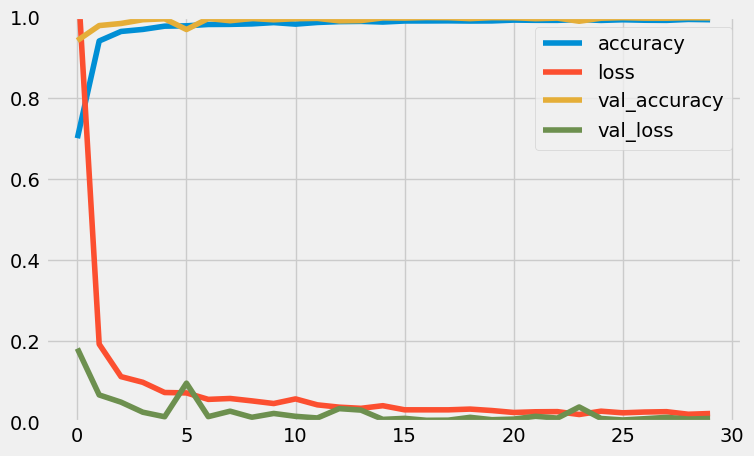

In [56]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

## Loading the test data and running the predictions

In [58]:
test = pd.read_csv(data_dir + '/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data =[]

for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)
X_test = X_test/255

In [60]:
pred = np.argmax(model.predict(X_test), axis=-1)

395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step


In [61]:
# pred = model.predict_classes(X_test)

#Accuracy with the test data
print('Test Data accuracy: ',accuracy_score(labels, pred)*100)

Test Data accuracy:  98.23436262866193


## Visualizing the confusion matrix

In [62]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(labels, pred)

<Axes: >

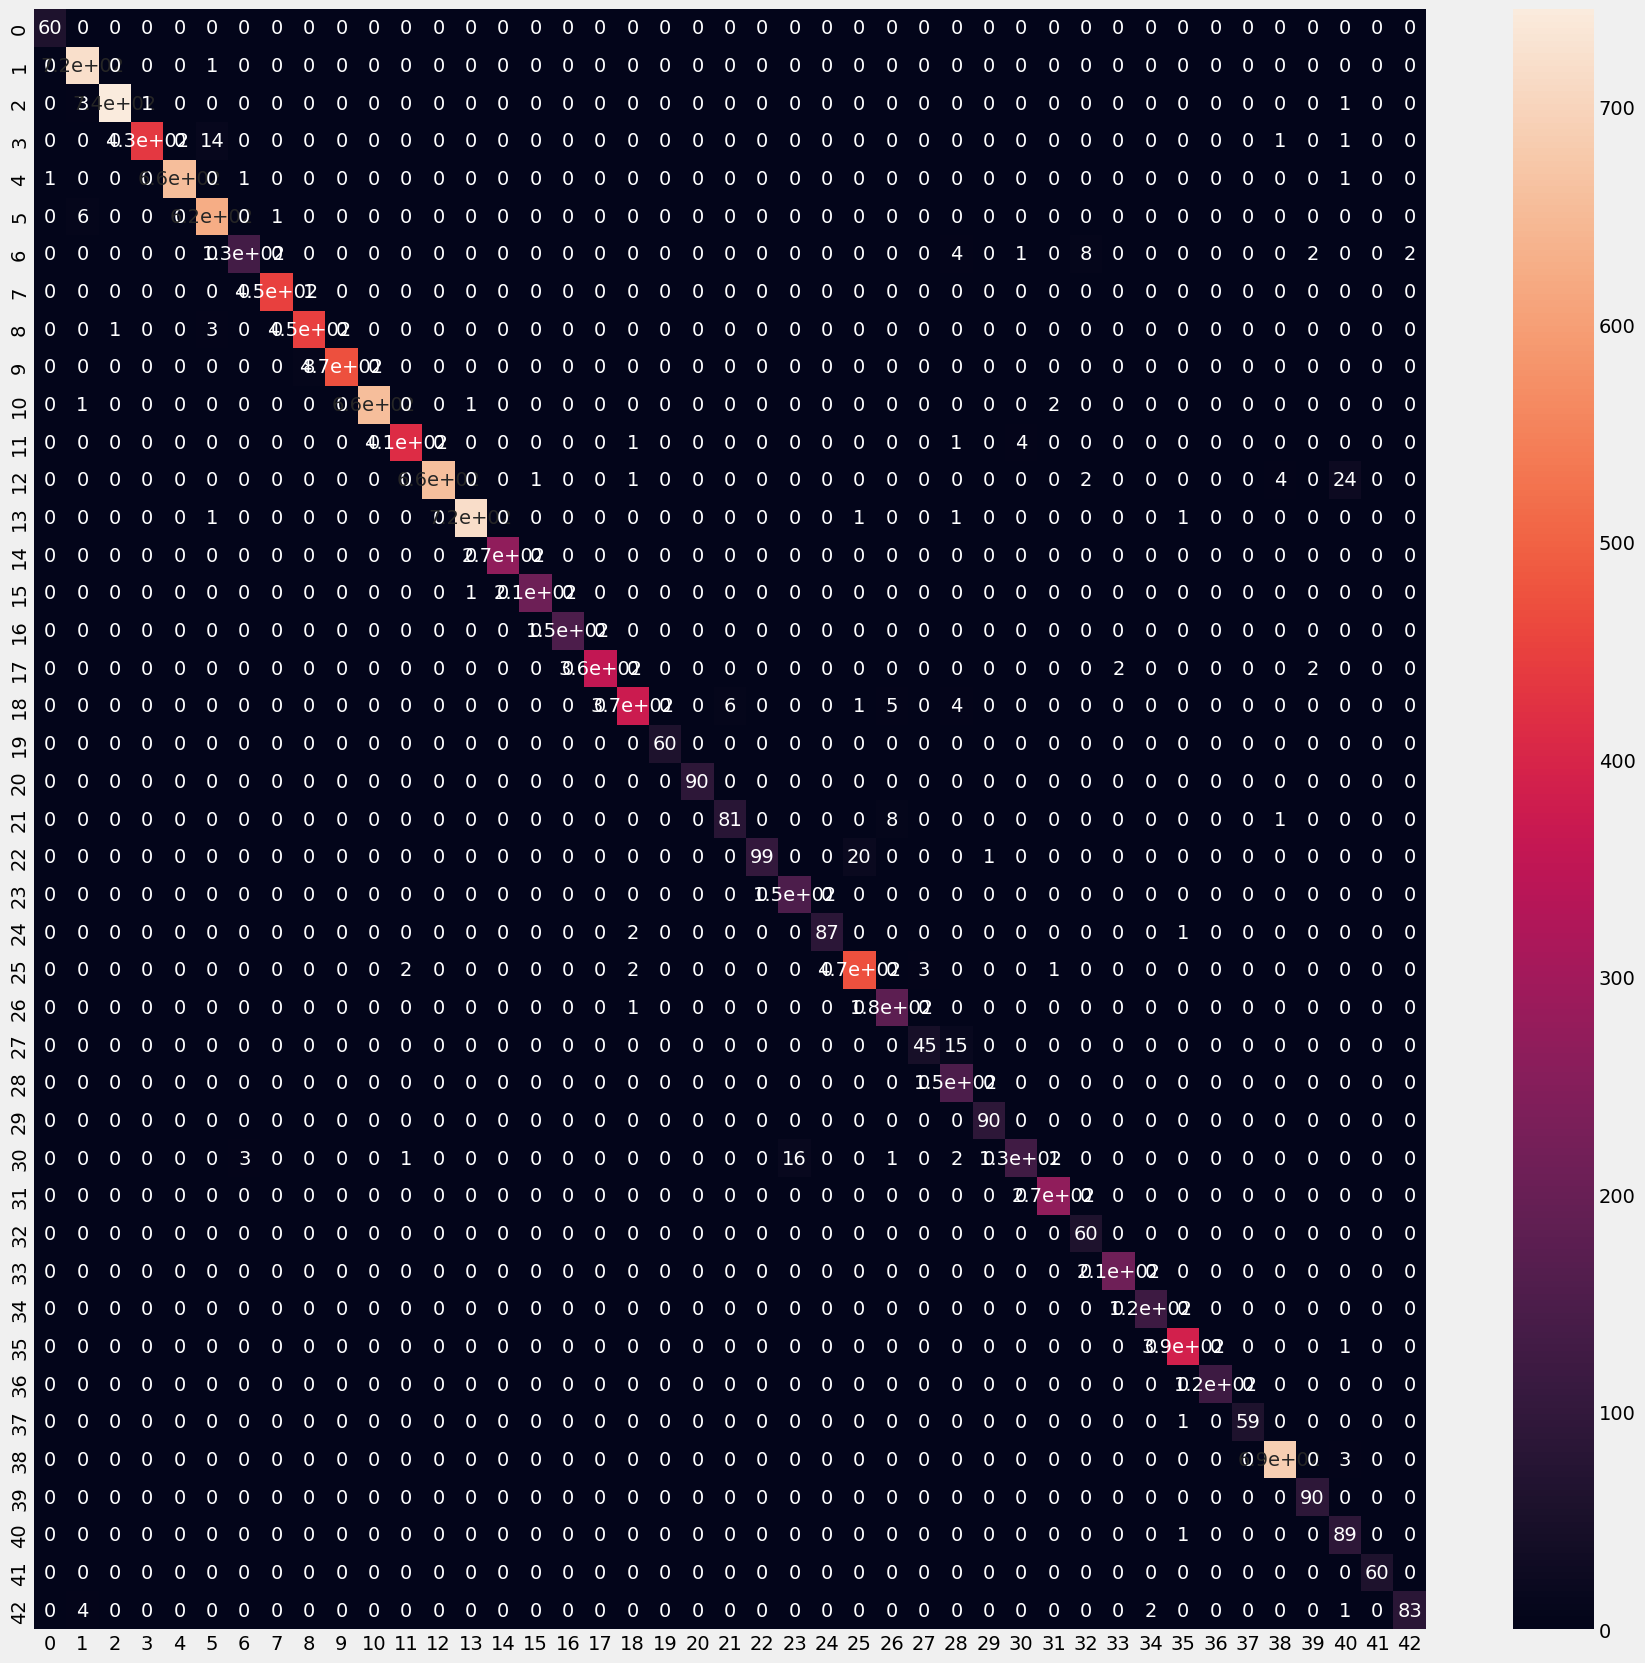

In [63]:
import seaborn as sns
df_cm = pd.DataFrame(cf, index = classes,  columns = classes)
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)

## Classification report

In [64]:
from sklearn.metrics import classification_report

print(classification_report(labels, pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        60
           1       0.98      1.00      0.99       720
           2       1.00      0.99      1.00       750
           3       1.00      0.96      0.98       450
           4       1.00      1.00      1.00       660
           5       0.97      0.99      0.98       630
           6       0.97      0.89      0.93       150
           7       1.00      1.00      1.00       450
           8       0.98      0.99      0.99       450
           9       1.00      0.98      0.99       480
          10       1.00      0.99      1.00       660
          11       0.99      0.99      0.99       420
          12       1.00      0.95      0.98       690
          13       1.00      0.99      1.00       720
          14       1.00      1.00      1.00       270
          15       1.00      1.00      1.00       210
          16       1.00      1.00      1.00       150
          17       1.00    

## Predictions on Test Data

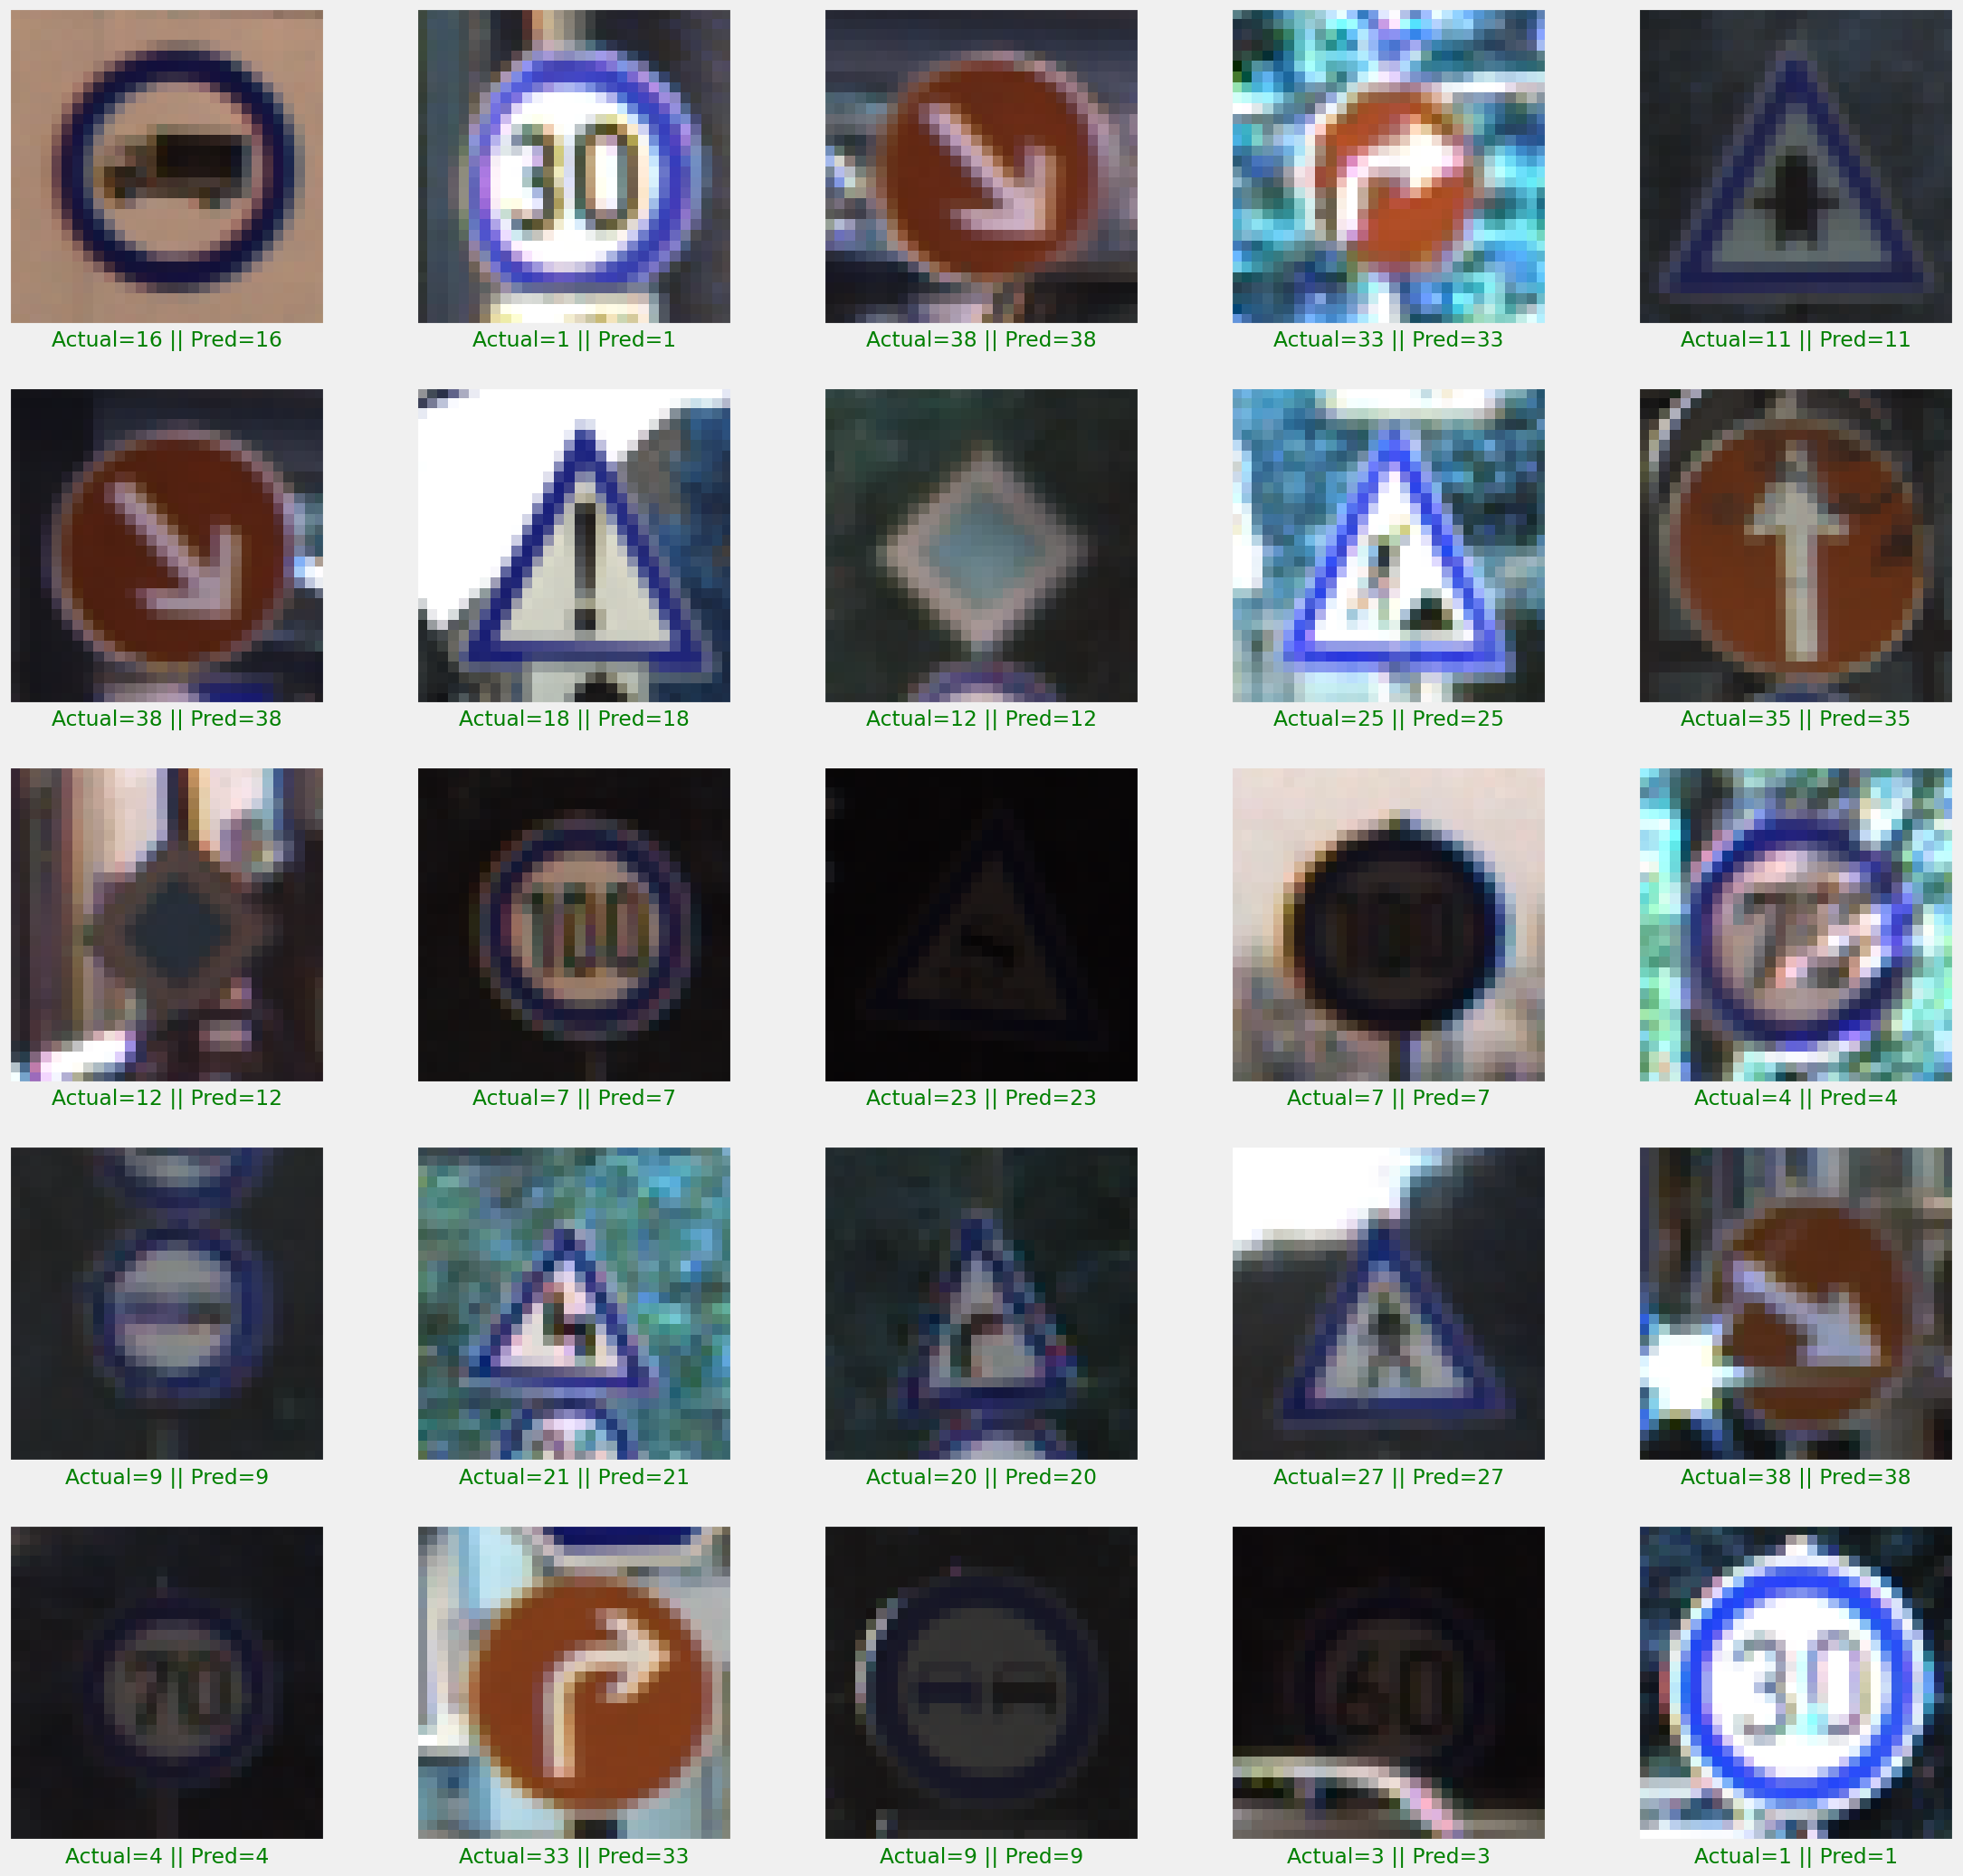

In [65]:
plt.figure(figsize = (25, 25))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred[start_index + i]
    actual = labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(X_test[start_index + i])
plt.show()

- Save the Model

In [69]:
# Save the model
model_save_path = '/content/drive/MyDrive/CNN-Model/img_model.h5'
model.save(model_save_path)